In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess
from scipy.linalg import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
import aesara.tensor as at
from theano.tensor.slinalg import cholesky

starry.config.quiet = True
np.random.seed(1)

In [2]:
# Planet orbit
p_inc = 88.0
p_ecc = 0.2
p_Omega = 100.0
p_w = 30.0
p_porb = 1.0
p_t0 = 0.5
p_r = 0.1

# Star
s_inc = 75
s_u = [0.4, 0.2]
s_prot = 4.3

# Gaussian process for the spots
gp_mu = 30.0
gp_sig = 5.0
gp_r = 10.0
gp_c = 0.1
gp_n = 10.0

# Time array (10 days @ 1 min cadence)
t = np.arange(0, 10, 1 / 24 / 60)

In [3]:
# Get the Cartesian position of the planet
star = starry.Primary(starry.Map())
planet = starry.Secondary(
    starry.Map(),
    inc=p_inc,
    ecc=p_ecc,
    Omega=p_Omega,
    w=p_w,
    porb=p_porb,
    t0=p_t0
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]

In [4]:
# Get the flux design matrix
map = starry.Map(15, len(s_u))
map.inc = s_inc
for n, coeff in enumerate(s_u):
    map[n + 1] = coeff
theta = (360 * t / s_prot) % 360
A = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

In [5]:
A.shape

(14401, 256)

In [6]:
# Draw 10 samples from the GP
sp = StarryProcess(mu=gp_mu, sigma=gp_sig, r=gp_r, c=gp_c, n=gp_n)
y = sp.sample_ylm(nsamples=10).eval().T

In [7]:
# Starry process Ylms are normalized so that they have
# zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
# Let's renormalize it to unity, since that's the baseline
# we want for transits
y[0] += 1

In [8]:
# Compute the light curves
flux0 = (A @ y).T

In [9]:
error = 1e-3
err = np.ones_like(flux0) * error
flux = np.array(flux0)
flux += np.random.randn(len(t)) * err

In [10]:
Sigma_ylm = sp.cov_ylm
Sigma = A @ Sigma_ylm.eval() @ np.transpose(A)
Sigma += err[0]**2*np.eye(len(t))
np.linalg.slogdet(Sigma)

(1.0, -198747.46567450272)

In [11]:
flux.shape

(10, 14401)

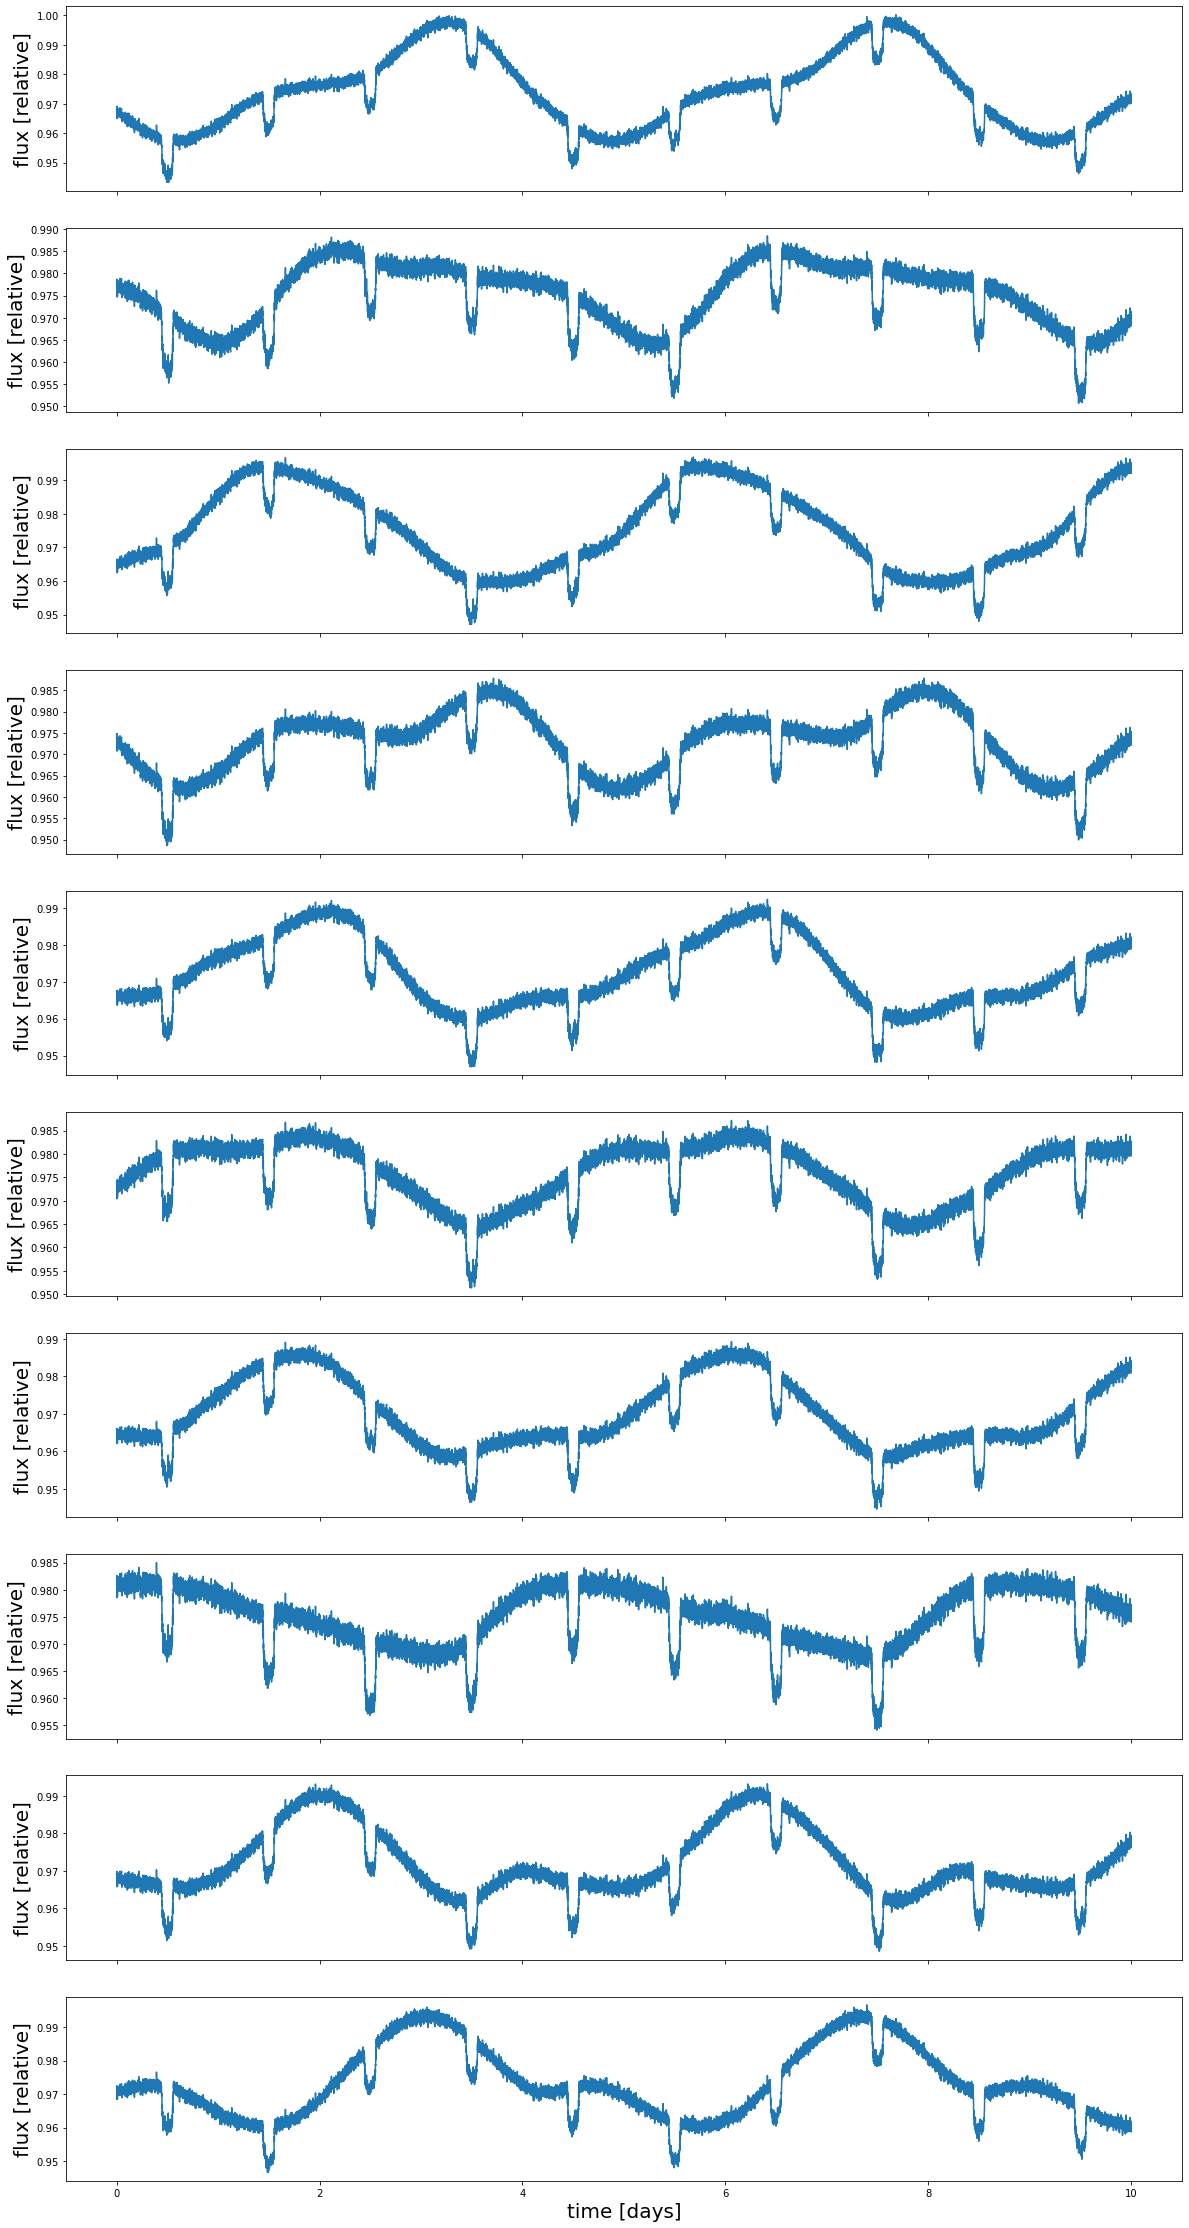

In [12]:
# Plot them
fig, ax = plt.subplots(10, figsize=(20, 40), sharex=True)
for n in range(len(flux)):
    ax[n].plot(t, flux[n])
    ax[n].set_ylabel("flux [relative]", fontsize=20)
ax[-1].set_xlabel("time [days]", fontsize=20);

# Binning the data

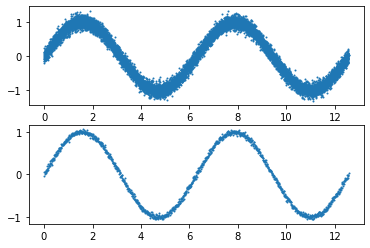

In [13]:
import scipy.stats

rng = np.random.default_rng(12345)
xs = np.linspace(0, 4 * np.pi, 12211)

orig = np.sin(xs)
noisy = orig + 0.1 * rng.standard_normal(xs.shape)

num_bins = xs.shape[0] // 10
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(
    xs, noisy, statistic="mean", bins=num_bins
)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[1:] - bin_width / 2

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(xs, noisy, 1)
ax2.scatter(bin_centers, bin_means, 1)
plt.show()

In [14]:
a = p_porb**(2/3) # semi-major axis
b = a*np.cos(p_inc)/1. # impact parameter

In [15]:
shifted = t-p_t0+0.06 # I tuned this parameter a little 
duration = p_porb/np.pi*np.arcsin(np.sqrt((1+p_r)**2-b**2)/a) 
# find all values >= target and < target + duration, modulo period
idx = (shifted >= 0) & (shifted % p_porb <= duration)
idx

array([False, False, False, ..., False, False, False])

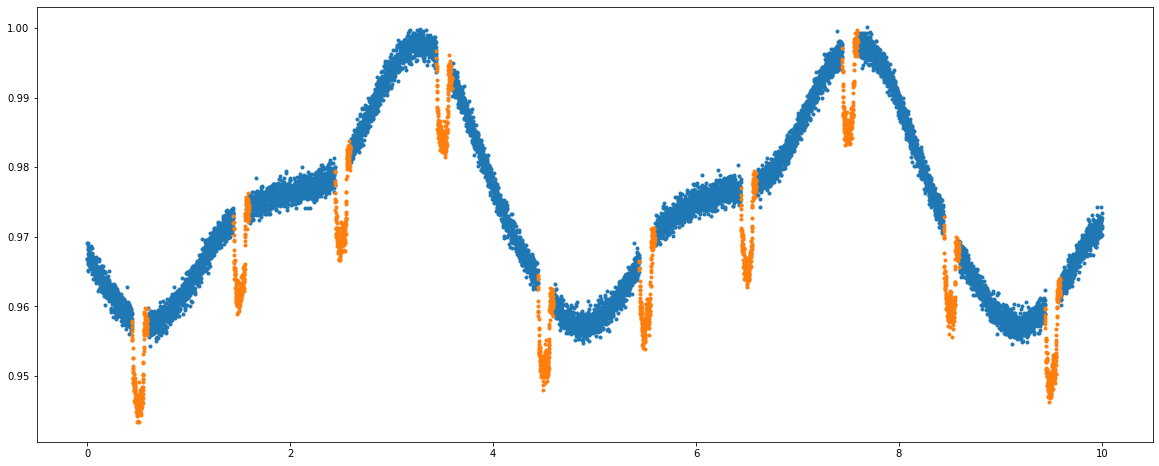

In [16]:
plt.figure(figsize=(20,8))
plt.plot(t[~idx],flux[0][~idx],'.')
plt.plot(t[idx],flux[0][idx],'.')

In [17]:
tprim = t[~idx]
frim = flux[0][~idx]

tbin = tprim[:10000].reshape(-1,100).mean(axis=1)
fbin = frim[:10000].reshape(-1,100).mean(axis=1)

In [18]:
tprim.shape

(12211,)

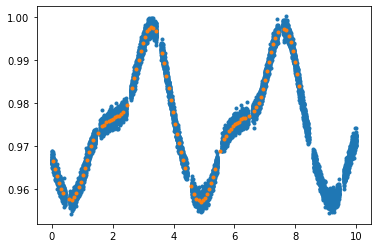

In [19]:
plt.plot(tprim,frim,'.')
plt.plot(tbin,fbin,'.')

In [20]:
num_bins = t[~idx].shape[0] // 10
flux0_binned_temp, bin_edges, binnumber = scipy.stats.binned_statistic(
    t[~idx], flux[0][~idx], statistic="mean", bins=num_bins
)
bin_width = bin_edges[1] - bin_edges[0]
t_binned_temp = bin_edges[1:] - bin_width / 2

(4.0, 6.0)

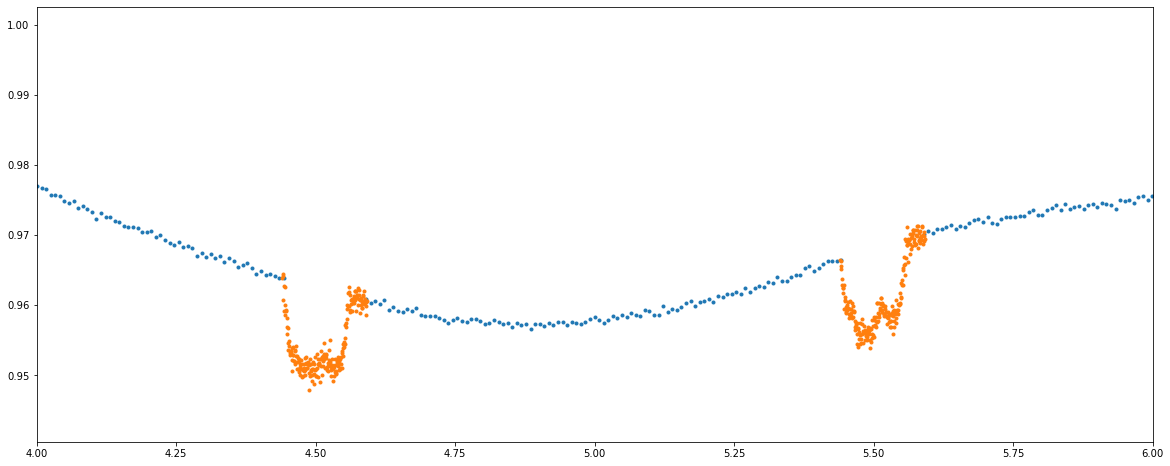

In [21]:
plt.figure(figsize=(20,8))
plt.plot(t_binned_temp, flux0_binned_temp,'.')
plt.plot(t[idx], flux[0][idx], '.')
plt.xlim(4,6)

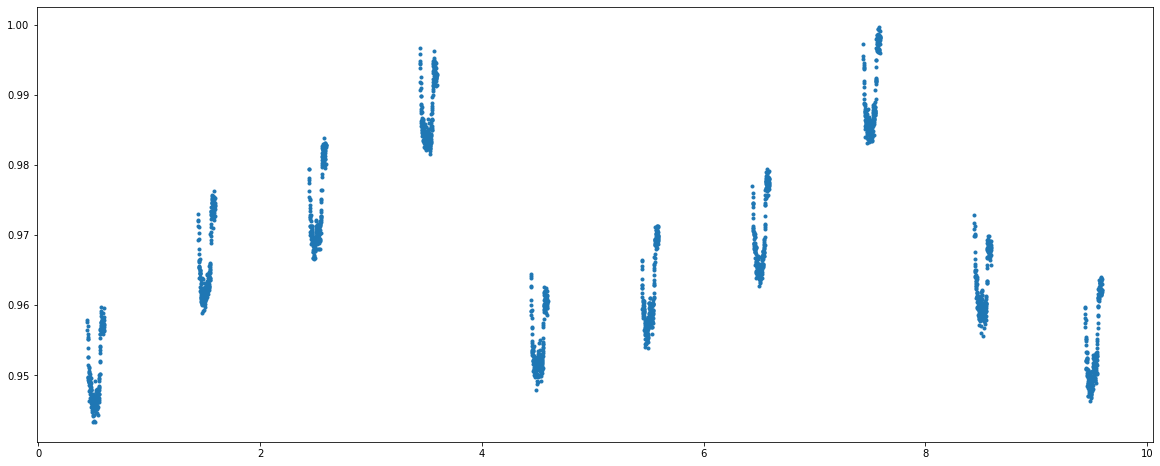

In [22]:
plt.figure(figsize=(20,8))
plt.plot(t[idx], flux[0][idx], '.')

In [23]:
# General function to bin the out-of-transit data
def bin_lc(x,y,mask):
    num_bins = x[~mask].shape[0] // 10
    binned_means, bin_edges, binnumber = scipy.stats.binned_statistic(
        x[~mask], y[~mask], statistic="mean", bins=num_bins
    )
    bin_width = bin_edges[1] - bin_edges[0]
    x_binned = bin_edges[1:] - bin_width / 2
    
    x_merged = np.concatenate((x_binned, x[mask]))
    y_merged = np.concatenate((binned_means, y[mask]))
    order = x_merged.argsort()
    x_merged = x_merged[order]
    y_merged = y_merged[order]

    x_merged=x_merged[~np.isnan(y_merged)]
    y_merged=y_merged[~np.isnan(y_merged)]

    return x_merged,y_merged

In [24]:
t1i = p_t0
t1f = p_t0+duration
t2i = p_t0+duration+p_porb
t2f = p_t0+2*duration+p_porb
t3i = p_t0+2*duration+2*p_porb

In [25]:
np.where(idx==True)[0][220]

2075

In [26]:
chunk = []
temp1 = 0
Y = []
X = []
for n in range(len(np.where(idx==True)[0])):
    if np.where(idx==True)[0][n] == np.where(idx==True)[0][-1]:
        break
    if (np.where(idx==True)[0][n+1] - np.where(idx==True)[0][n]-1) == 0:
        chunk.append(np.where(idx==True)[0][n])
    else:
        temp2 = chunk[0] 
        # plt.figure(figsize=(20,8))
        # plt.plot(t[temp1:temp2], flux[0][temp1:temp2], '.')

        num_bins = t[temp1:temp2].shape[0] // 10
        binned_means, bin_edges, binnumber = scipy.stats.binned_statistic(
            t[temp1:temp2], flux[0][temp1:temp2], statistic="mean", bins=num_bins
        )
        bin_width = bin_edges[1] - bin_edges[0]
        x_binned = bin_edges[1:] - bin_width / 2
        
        x_merged = np.concatenate((x_binned, t[chunk]))
        y_merged = np.concatenate((binned_means, flux[0][chunk]))
        order = x_merged.argsort()
        x_merged = x_merged[order]
        y_merged = y_merged[order]

        x_merged=x_merged[~np.isnan(y_merged)]
        y_merged=y_merged[~np.isnan(y_merged)]

        # plt.figure(figsize=(20,8))
        # plt.plot(x_merged, y_merged, '.')

        X.append(x_merged)
        Y.append(y_merged)
        
        temp1 = chunk[-1]
        chunk = []
        continue

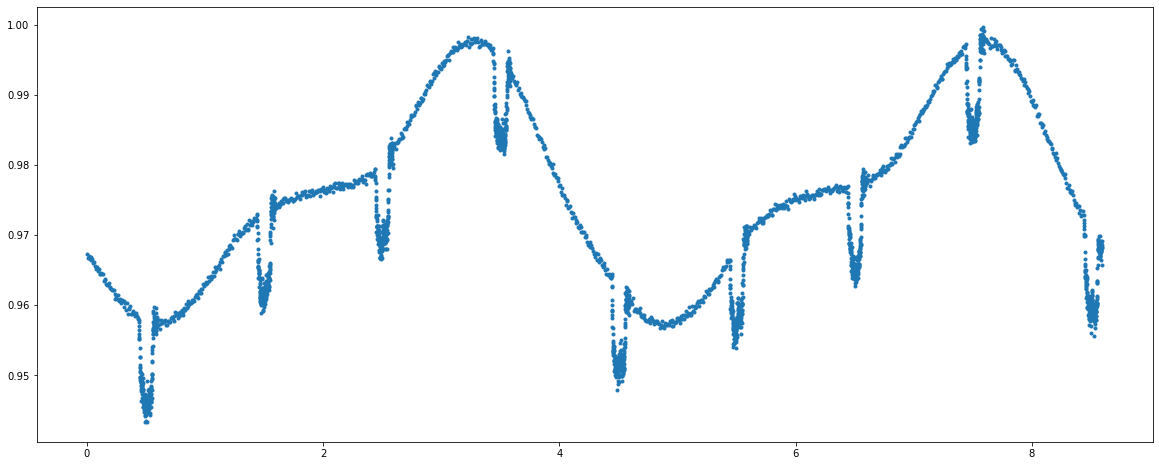

In [27]:
t_bin = np.concatenate(X)
y_bin = np.concatenate(Y)
plt.figure(figsize=(20,8))
plt.plot(t_bin, y_bin, '.')

In [28]:
y_bin.shape

(3001,)

In [29]:
t_binned,y_binned = bin_lc(t,flux[0],idx)

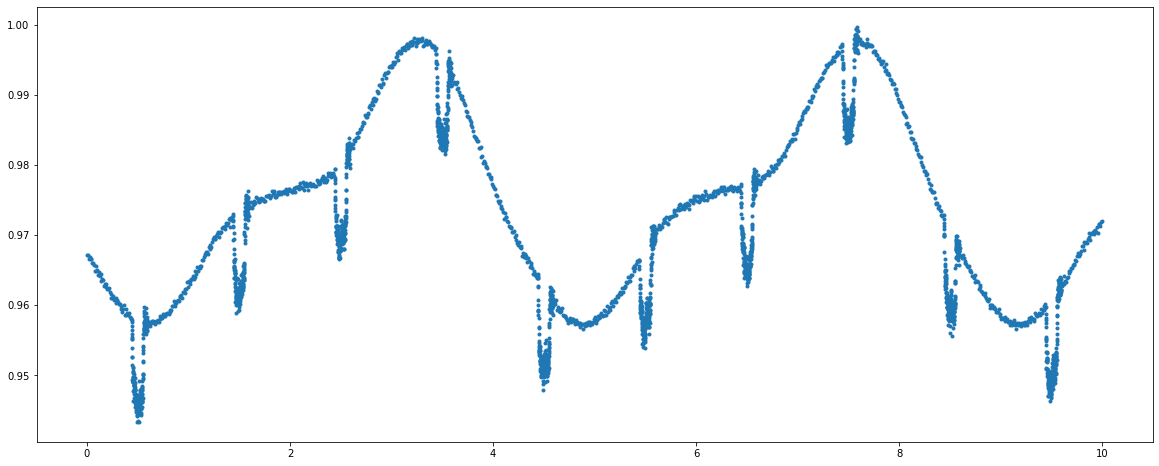

In [30]:
plt.figure(figsize=(20,8))
plt.plot(t_binned, y_binned, '.')

# Computing the marginal likelihood

In [31]:
# this is the new design matrix for the BINNED data
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t_binned)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t_binned / s_prot) % 360
A_new = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

In [32]:
A_new.shape

(3234, 256)

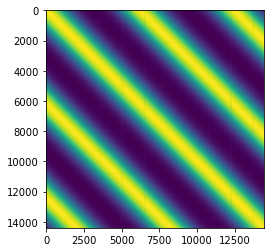

In [33]:
plt.imshow(Sigma)

In [34]:
# Compute the marginal likelihood dumb way
mean = A @ sp.mean_ylm.eval() + 1
N = len(t)
def ln_likelihood_dumb(t, y, sigma, **kwargs): #sigma is covariance here
    return -1/2*np.dot(np.dot((y-mean).T,np.linalg.inv(sigma)),(y-mean)) -1/2*np.linalg.slogdet(sigma)[1]-N/2*np.log(2*np.pi)

In [35]:
# Compute the marginal likelihood
K = len(t)
cho_gp_cov,low = scipy.linalg.cho_factor(Sigma, lower=True)
mean = tt.reshape(A @ sp.mean_ylm.eval() + 1, (K, 1))
r = (
    tt.reshape(tt.transpose(tt.as_tensor_variable(flux[0])), (K, -1))
    - mean
)
M = r.shape[1]
loglike = -0.5 * tt.sum(
        tt.batched_dot(
            tt.transpose(r), np.transpose(scipy.linalg.cho_solve((np.asarray(cho_gp_cov),low), r.eval()))
        )
    )
loglike -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
loglike -= 0.5 * K * M * tt.log(2 * np.pi)

In [36]:
loglike.eval()

array(19547.56350104)

In [37]:
# Compute the marginal likelihood for the binned data
Sigma_bin = A_new @ sp.cov_ylm.eval() @ A_new.T
error = 1e-3/np.sqrt(len(t_binned))
err_bin = np.ones_like(y_binned) * error
Sigma_bin += err_bin**2*np.eye(len(t_binned))
K = len(t_binned)
cho_gp_cov,low = scipy.linalg.cho_factor(Sigma_bin,lower=True)
mean_bin = tt.reshape(A_new @ sp.mean_ylm.eval() + 1, (K, 1))
r = (
    tt.reshape(tt.transpose(tt.as_tensor_variable(y_binned)), (K, -1))
    - mean_bin
)
M = r.shape[1]
loglike_bin = -0.5 * tt.sum(
        tt.batched_dot(
            tt.transpose(r), np.transpose(scipy.linalg.cho_solve((np.asarray(cho_gp_cov), low), r.eval()))
        )
    )
loglike_bin -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
loglike_bin -= 0.5 * K * M * tt.log(2 * np.pi)

In [38]:
loglike_bin.eval()

array(-16378515.55206945)

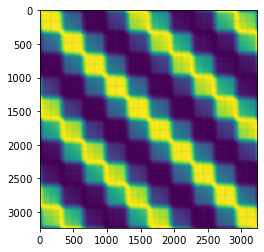

In [39]:
plt.imshow(Sigma_bin)

In [40]:
# ln_likelihood_dumb(t,flux[0],Sigma)

In [41]:
from starry_process.math import cho_factor,cho_solve
starry.config.lazy = True
with pm.Model() as model:
    # Params for the flux model
    # Orbital parameters for the planet.
    # porb = pm.Normal("porb", mu=1.0, sigma=0.001)
    # t0 = pm.Normal("t0", mu=0.5, sigma=0.01)
    # u1 = pm.Uniform("u1", lower=0.39, upper=0.41)
    # u2 = pm.Uniform("u2", lower=0.19, upper=0.21)
    rp = pm.Uniform("rp", lower=0.09, upper=0.11)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly, ecept for the limb-darkening coefficients
    star = starry.Primary(starry.Map())
    planet = starry.Secondary(
        starry.Map(),
        inc=p_inc,
        ecc=p_ecc,
        Omega=p_Omega,
        w=p_w,
        porb=p_porb,
        t0=p_t0
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_binned)

    # Get the flux design matrix
    map = starry.Map(15, len(s_u))
    map.inc = s_inc
    for n, coeff in enumerate(s_u):
        map[n + 1] = coeff
    theta = (360 * t_binned / s_prot) % 360
    A = map.design_matrix(theta=theta, xo=xo[0], yo=yo[0], zo=zo[0], ro=rp)

    mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

    # flux_model = pm.Deterministic(
    #         "flux_model", (sys.flux(t)-1)*1e3
    #     )

    # Things we know
    # u = [u1,u2]
    ferr = 1e-3

    # Spot latitude params. Isotropic prior on the mode
    # and uniform prior on the standard deviation
    unif0 = pm.Uniform("unif0", 0.0, 1.0)
    mu = 90 - tt.arccos(unif0) * 180 / np.pi
    pm.Deterministic("mu", mu)
    sigma = pm.Uniform("sigma", 1.0, 10.0)

    # Spot radius (uniform prior)
    rs = pm.Uniform("r", 10.0, 30.0)

    # Spot contrast & number of spots (uniform prior)
    c = pm.Uniform("c", 0.0, 0.5, testval=0.1)
    n = pm.Uniform("n", 1.0, 20.0, testval=10)

    # Inclination (isotropic prior)
    unif1 = pm.Uniform("unif1", 0.0, 1.0)
    i = tt.arccos(unif1) * 180 / np.pi
    pm.Deterministic("i", i)

    # Period (uniform prior)
    p = pm.Uniform("p", 0.75, 1.25)

    # Variability timescale (uniform prior)
    tau = pm.Uniform("tau", 0.1, 10.0)

    # # Instantiate the GP
    sp = StarryProcess(mu=mu, sigma=sigma, r=rs, c=c, n=n)

    # Compute the log likelihood
    # Cov matrix at the ylm basis
    Sigma_ylm = sp.cov_ylm
    K = len(t_binned)

    # Cov matrix
    Sigma = tt.dot(tt.dot(A,Sigma_ylm),A.T)
    # Sigma+=1 # adding the baseline
    Sigma += (err_bin[0]/np.sqrt(len(t_binned)))**2*np.eye(len(t_binned)) # add error to the covariance to make it positive definite
    cho_gp_cov = cho_factor(Sigma)
    mean1 = tt.reshape(tt.dot(A,sp.mean_ylm + 1), (K, 1))
    r = (
        tt.reshape(tt.transpose(tt.as_tensor_variable(y_binned)), (K, -1)) # this is for the first light curve!
        - mean1
    )
    M = r.shape[1]
    lnlikemod = -0.5 * tt.sum(
            tt.batched_dot(
                tt.transpose(r), tt.transpose(cho_solve(cho_gp_cov, r))
            )
        )
    lnlikemod -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
    lnlikemod -= 0.5 * K * M * tt.log(2 * np.pi)

    pm.Potential("lnlike", lnlikemod)

In [42]:
with model:
    loglike = pmx.eval_in_model(model['lnlike'])

In [43]:
loglike

array(-2.08834589e+11)

In [44]:
# Optimize the MAP solution.
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp]


message: Desired error not necessarily achieved due to precision loss.
logp: -208836210859.45267 -> -207648565631.86456


In [45]:
map_soln['c']

array(0.15446211)

In [46]:
map_soln['rp']

array(0.10554996)

In [47]:
map_soln['mu']

array(23.48399426)

In [48]:
map_soln['sigma']

array(7.01586766)

In [49]:
map_soln['n']

array(10.94134551)

In [52]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp]


In [ ]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp", "u2", "u1", "t0", "porb"])

NameError: name 'trace' is not defined

In [51]:
import arviz as az
with model:
    _ = az.plot_trace(trace, var_names=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp"])

ValueError: Can not extract posterior from <MultiTrace: 1 chains, 0 iterations, 21 variables>! See /opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/converters.py for other conversion utilities.

In [ ]:
def cholesky_decomposition(M):
    """
    return: upper triangular matrix with positive diagonal entries if M is SPD.
    """

    A = np.copy(M)
    n = len(t)
    R = np.zeros_like(A)

    for k in range(n):
        R[k, k] = np.sqrt(A[k, k])
        R[k, k + 1:] = A[k, k + 1:] / R[k, k]
        for j in range(k + 1, n):
            A[j, j:] = A[j, j:] - R[k, j] * R[k, j:]

    return R, True